In [2]:
!pip install d2l
!pip install matplotlib==3.0.0
import torch
from torch import nn
from d2l import torch as d2l


def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 通过is_grad_enabled来判断当前模式是训练模式还是预测模式
    if not torch.is_grad_enabled():
        # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差，使用全局方差
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        # 这里只考虑全连接层和卷积层的情况
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # 使用全连接层的情况，计算特征维上的均值和方差
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # 使用二维卷积层的情况，计算通道维上（axis=1）的均值和方差。
            # 这里我们需要保持X的形状以便后面可以做广播运算
            # dim=(0, 2, 3)表示X的批量大小和高宽
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # 训练模式下，用当前的均值和方差做标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 更新移动平均的均值和方差，momentum一般取0.9
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # 缩放和移位
    return Y, moving_mean.data, moving_var.data

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 4.5 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires matplotlib!=3.0.0,>=2.0.2, but you have matplotlib 3.0.0 which is incompatible.
scikit-image 0.18.3 requires matplotlib!=3.0.0,>=2.0.0, but you have matplotlib 3.0.0 which is incompatible.
plotnine 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.0 which is incompatible.
mizani 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.0 which is incompatibl

In [3]:
class BatchNorm(nn.Module):
    # num_features：完全连接层的输出数量或卷积层的输出通道数。
    # num_dims：2表示完全连接层，4表示卷积层
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0
        self.gamma = nn.Parameter(torch.ones(shape)) # 若初始化为0则后续乘X_hat无意义
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数的变量初始化为0和1
        self.moving_mean = torch.zeros(shape) 
        self.moving_var = torch.ones(shape) # 后续需要除以此参数，故不能初始化为0

    def forward(self, X):
        # 如果X不在内存上，将moving_mean和moving_var
        # 复制到X所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的moving_mean和moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y

In [4]:
# 批量规范化是在卷积层或全连接层之后、相应的激活函数之前应用的
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10))

loss 0.266, train acc 0.901, test acc 0.832
2405.8 examples/sec on cpu


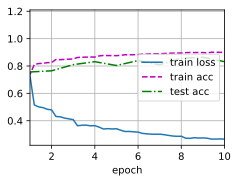

In [5]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())